# Decision Trees

Steve Pittard wsp@emory.edu (citations to other sources are inline) 

Tree-based methods employ a segmentation strategy that partitions the feature / predictor space into a series of decisions which has the added benefit of being easy to understand. Think of it as a flow chart for making an ultimate decision which is typically one or another (binary) as one might find in classification problems. 

The viewer of the final tree is presented with a diagram that offers outcomes in response to (yes / no) questions (decisions) about important predictors found in the data set. In reality, most people do NOT need to view a resulting tree because they can become difficult to read especially if there are lots of splits, leaves, and nodes. The scikit-learn desctription of a Decision Tree is:

> The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

The advantages of tree-based methods include:

   - The model is generally easy to interpret and explain
   - Mimics the decision making process of humans (sort of)
   - Transparent (assuming that the number of tree splits is easy enough to trace).
   - The method can handle numeric and categorical
   - No need to pre process or normalize data 

Disadvantages include:

   - Large trees are hard to follow - variance can be high
   - Trees can be overly complex
   - Overfitting can be a problem
   - When using aggregated trees (bagging) or boosted trees, there is no single tree to view



## Build A Tree On Simple Data

Let's build a decision tree on the mtcars data frame to predict whether a given car in the data frame represents an automatic (0) or manual transmission (1). Before we do that we might look at various relationships that might be observable which would allow us to make our own decsion tree without doing much in the way of math.

The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973-74 models). A data frame with 32 observations on 11 (numeric) variables.

- mpg  Miles/(US) gallon                        
- cyl  Number of cylinders                      
- disp  Displacement (cu.in.)                    
- hp    Gross horsepower                         
- drat  Rear axle ratio                          
- wt    Weight (1000 lbs)                        
- qsec  1/4 mile time                            
- vs    Engine (0 = V-shaped, 1 = straight)      
- am    Transmission (0 = automatic, 1 = manual) 
- gear  Number of forward gears                  
- carb  Number of carburetors                    
      


In [83]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"
mtcars = pd.read_csv(url)

y = mtcars.am
X = mtcars.drop('am',axis=1)

mtcars

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


Text(0, 0.5, 'carb')

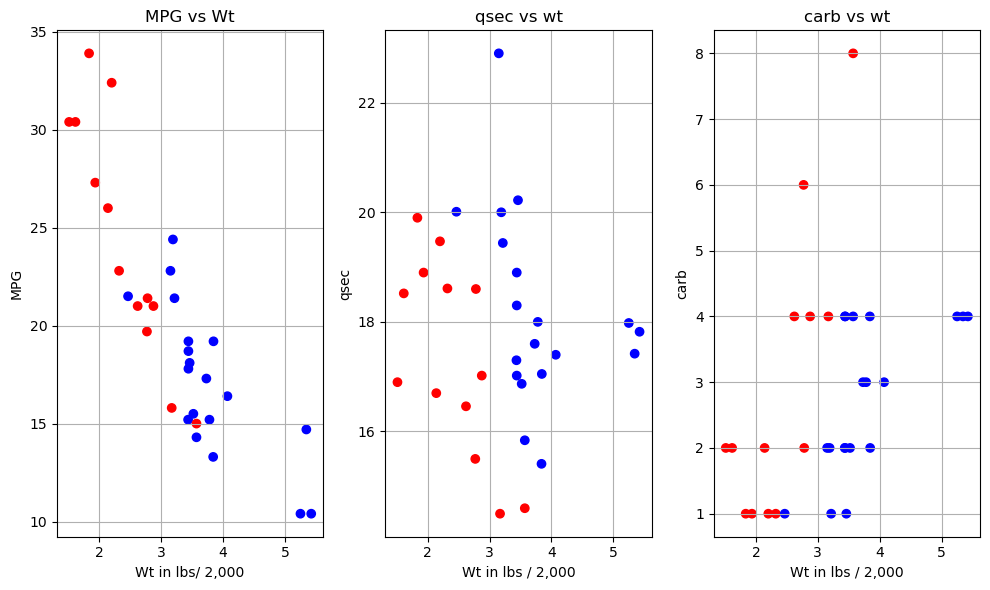

In [84]:
colors = {0:'blue', 1:'red'}
plt.figure(figsize=(10,6),tight_layout=True)
plt.subplot(1,3,1)
plt.scatter(mtcars['wt'], mtcars['mpg'], c=mtcars['am'].map(colors))
plt.grid()
plt.title("MPG vs Wt")
plt.ylabel("MPG")
plt.xlabel("Wt in lbs/ 2,000")

plt.subplot(1,3,2)
plt.scatter(mtcars['wt'], mtcars['qsec'], c=mtcars['am'].map(colors))
plt.grid()
plt.title("qsec vs wt")
plt.xlabel("Wt in lbs / 2,000")
plt.ylabel("qsec")

plt.subplot(1,3,3)
plt.scatter(mtcars['wt'], mtcars['carb'], c=mtcars['am'].map(colors))
plt.grid()
plt.title("carb vs wt")
plt.xlabel("Wt in lbs / 2,000")
plt.ylabel("carb")

The benfit of this approach is that we can see what variables might be more important in making an ultimate decision on whether a car is automatic or manual. This data is pretty simple and if you know anything about cars then you might be able to intuit this yourself. We could look at a pairs plot to generalize the visualization

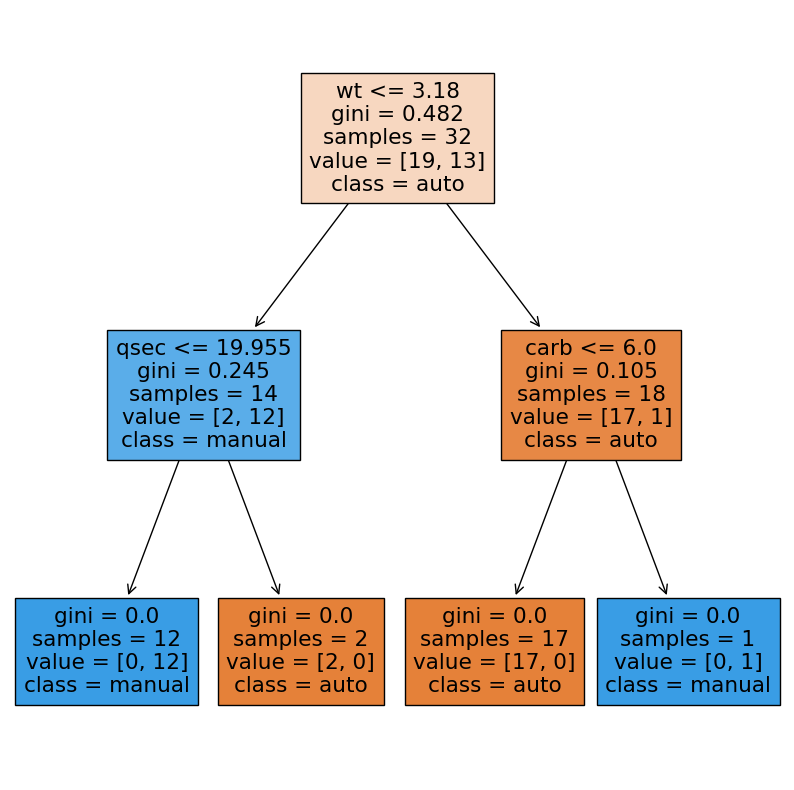

In [85]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"
mtcars = pd.read_csv(url)

y = mtcars.am
X = mtcars.drop('am',axis=1)


feature_names = list(X.columns)
classnames = mtcars.am.map({1:'m',0:'a'})
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X,y)

plt.figure(figsize=(10,10))

myt = tree.plot_tree(clf,feature_names=feature_names,
                     class_names=['auto','manual'],filled=True)

In reference to the above tree let's trace through it to see how it works. The “node” at the top is called the “root node” and the lines are “branches” that go either to a “terminal node” or to “leaf nodes” which involve some comparison. 

The first split looks a the **wt** variable although what we don't see is that under the covers, the method will look at all features in an attempt to identify the one that will maximize "purity" (or minimize impurity). In this case, it turns out that **wt** seems to be important in whether a car has an automatic vs manual tranmission. We start out with 32 samples and then filter the data on cars that are less than or equal to 3.18. Note that weight is in lbs/2,000. 

In [86]:
# We get 14 rows which matches the left side of the tree
print(mtcars[mtcars['wt'] <= 3.18].shape[0])

# 2 of those are automatic and 12 are manual
print(mtcars[mtcars['wt'] <= 3.18].am.value_counts())

14
am
1    12
0     2
Name: count, dtype: int64


In [87]:
# Then we look at qsec to see if it less than or equal to 19.95
next_leaf = mtcars[mtcars['wt'] <= 3.18]
print(next_leaf[next_leaf['qsec'] <= 19.95].am.value_counts())

am
1    12
Name: count, dtype: int64


So we could do the same thing for the right side of the tree but that's left as an exercise for you to do. Notice that as move down the tree the Gini value decreases with an eventual value of 0.00 which means that the resulting node / leaf is "pure". However, we could build a tree that does not NEED to terminate with a Gini value of 0.0. In fact, it might be useful not to require that since to do so might result in a highly specific tree.

It's important to point out that the method has arguments that we can use to influence how things turn out. We could, for example, restrict the tree to a "stumpt" by saying we only want a tree of depth 1.

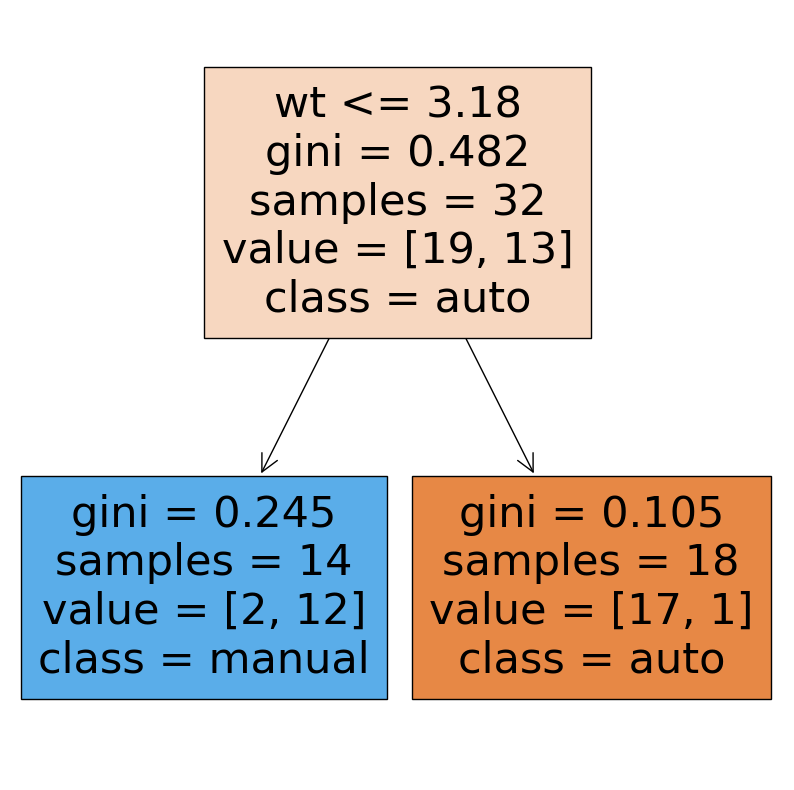

In [88]:
clf = DecisionTreeClassifier(random_state=0,max_depth=1)
clf.fit(X,y)

feature_names = list(X.columns)
plt.figure(figsize=(10,10))

myt = tree.plot_tree(clf,feature_names=feature_names,
                     class_names=['auto','manual'],filled=True)

### Experimention With Arguments

If you take a look at the default parameters of DecisonTree:

    max_depth=None
    max_leaf_nodes=None
    max_features=None
    min_samples_leaf=1
    min_samples_split=2

These almost guarantee that any tree will be overfit so we could look at any of these such as "max_features" Look what happens when we tell the method how many features to consider when figuring out how to create new leafs. A popular choice is "sqrt" which takes the square root of the total number of predictor features. 

Training Score: 1.0


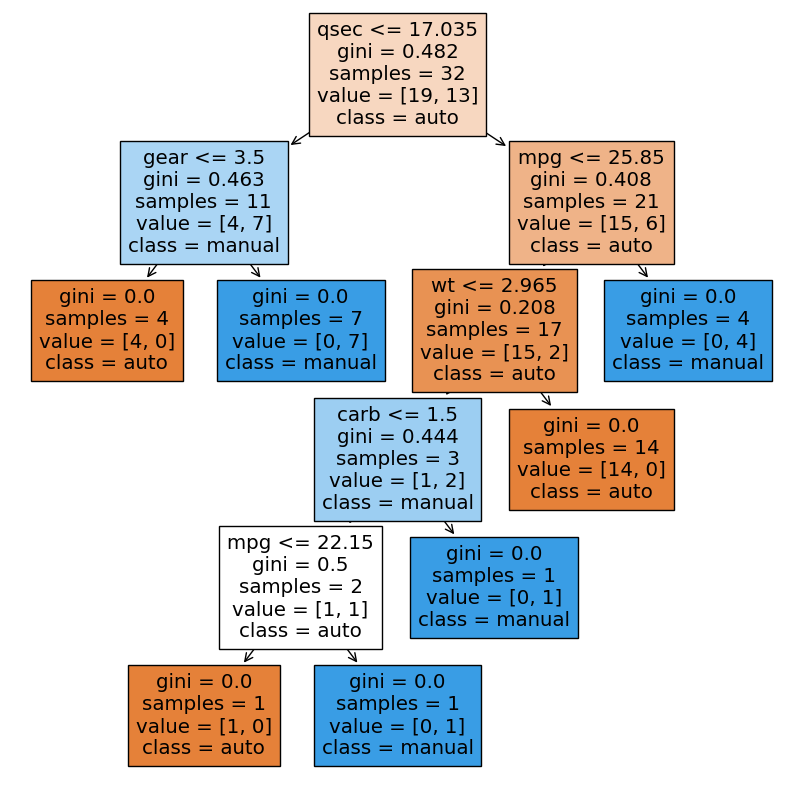

In [89]:
clf = DecisionTreeClassifier(random_state=0,max_features='sqrt')
clf.fit(X,y)
print("Training Score:",clf.score(X,y))
plt.figure(figsize=(10,10))

feature_names = clf.feature_names_in_
myt = tree.plot_tree(clf,feature_names=list(X.columns),
                     class_names=['auto','manual'],filled=True)

The resulting tree is harder to read and has leaves with just 1,2, or 3 samples which might suggest that we are getting to specific in how the tree is getting made. That is, the bias might be lower but the variance of the resulting tree might not generalize well to unseen data. On the other hand it does what we asked it to do. We could continue to play this game. We can require a leaf to have a minimum number of samples in it. This forces the model to be less specific to the data possibly resulting in higher bias but that's not necessarily a bad thing. 

Training Score is: 0.875


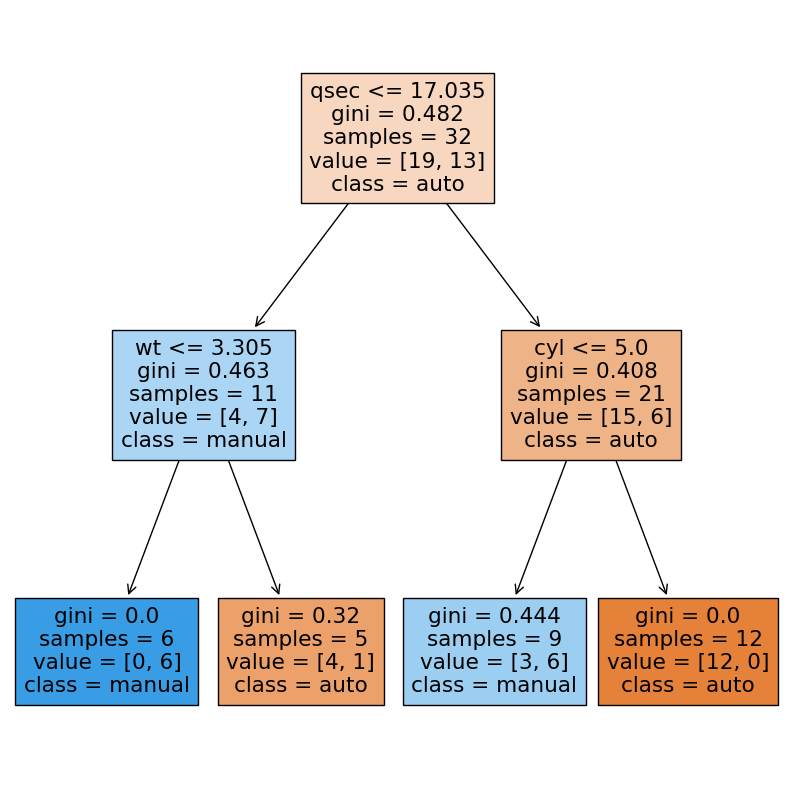

In [90]:
clf = DecisionTreeClassifier(random_state=0,max_features='sqrt',min_samples_leaf=5)
clf.fit(X,y)

plt.figure(figsize=(10,10))

myt = tree.plot_tree(clf,feature_names=list(X.columns),
                     class_names=['auto','manual'],filled=True)
print("Training Score is:",clf.score(X,y))

What we also notice is that the trees we generate can be very different from the one before so we have concerns about how well we could trust the model on new data. However, one major advantage of a single Decision Tree is that it's really easy to see how it arrives at an ultimate decision. So this approach has a high degree of transparency that "Bagged" and "Boosted" trees do not have even though they might offer better performance. See [this website](https://medium.com/turo-engineering/how-not-to-use-random-forest-265a19a68576) for more information on using RandomForests intelligently.

Training Score is: 0.92
Testing Score is: 0.857


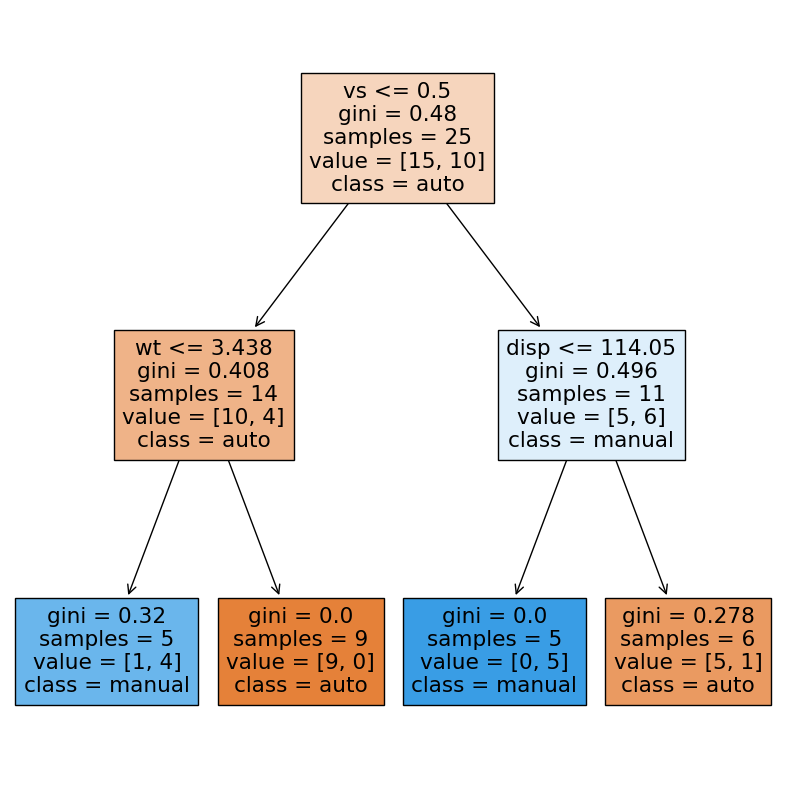

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

clf = DecisionTreeClassifier(random_state=0,
                             max_features='sqrt',
                             min_samples_leaf=5)
clf.fit(X_train,y_train)

feature_names = list(X.columns)
plt.figure(figsize=(10,10))

myt = tree.plot_tree(clf,feature_names=feature_names,
                     class_names=['auto','manual'],filled=True)
print("Training Score is:",clf.score(X_train,y_train).round(3))
print("Testing Score is:",clf.score(X_test,y_test).round(3))

Compare the above to the following which accepts all the detaults which will lead to a very high training accuracy but a miserable testing accuracy.

Training Score is: 1.0
Testing Score is: 0.571


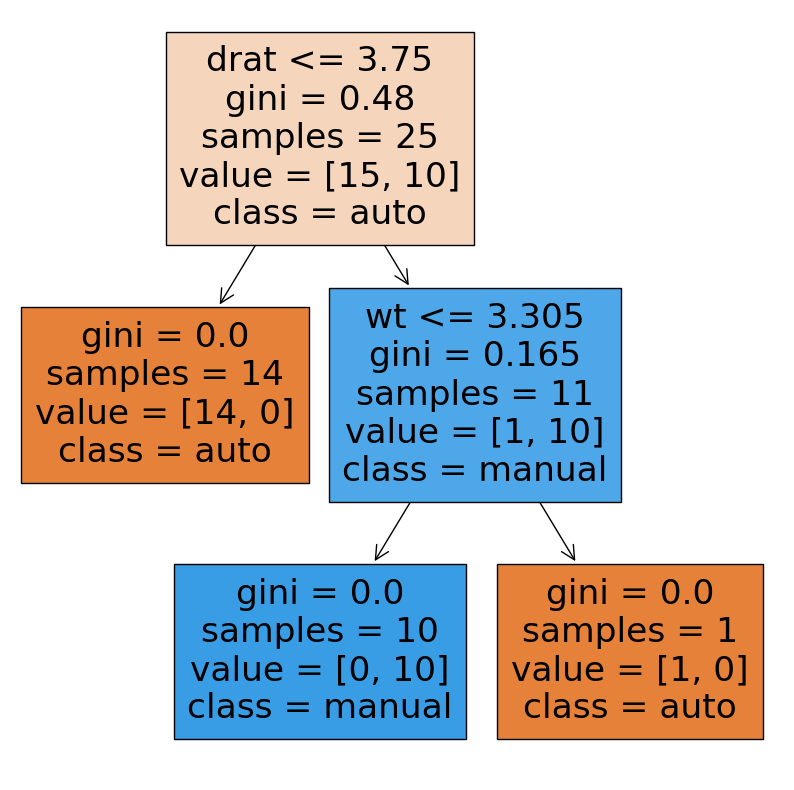

In [92]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)

plt.figure(figsize=(10,10))

feature_names = list(X.columns)
myt = tree.plot_tree(clf,feature_names=feature_names,
                     class_names=['auto','manual'],filled=True)
print("Training Score is:",clf.score(X_train,y_train).round(3))
print("Testing Score is:",clf.score(X_test,y_test).round(3))

## More Involved Data

Let’s use the Pima Indians data set as it relates to predicting whether someone has diabetes. The relevant variables are:

    pregnant - Number of times pregnant
    glucose  - Plasma glucose concentration (glucose tolerance test)
    pressure - Diastolic blood pressure (mm Hg)
    triceps  - Triceps skin fold thickness (mm)
    insulin  - 2-Hour serum insulin (mu U/ml)
    mass       - Body mass index (weight in kg/(height in m)\^2)
    pedigree - Diabetes pedigree function
    age      - Age (years)
    diabetes - Class variable (test for diabetes)



In [93]:
# Read in the Data
import pandas as pd
url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/pima.csv"
pm = pd.read_csv(url, sep=',')

In [95]:
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.model_selection import KFold

X = pm.drop('diabetes',axis=1)
y = pm.diabetes

lb = preprocessing.LabelBinarizer(neg_label=0, pos_label=1)
y  = lb.fit(y).transform(y)

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

dtf = DecisionTreeClassifier(max_depth = 2)

# fitting the data in the pipe 
dtf.fit(X_train, y_train) 
  
# scoring data  
print("Classification Report for Testing Data\n")
print(classification_report(y_test,dtf.predict(X_test)))

# training data
print("Classification Report for Training Data\n")
print(classification_report(y_train,dtf.predict(X_train)))

Classification Report for Testing Data

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       124
           1       0.71      0.40      0.51        68

    accuracy                           0.73       192
   macro avg       0.72      0.65      0.66       192
weighted avg       0.73      0.73      0.71       192

Classification Report for Training Data

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       376
           1       0.72      0.49      0.59       200

    accuracy                           0.76       576
   macro avg       0.74      0.70      0.71       576
weighted avg       0.75      0.76      0.74       576



As with mtcars, one thing you should notice about a single tree is that it is easy to generate and, if the specified depth isn't too deep, easy to visualize. Let's plot the tree we just created.

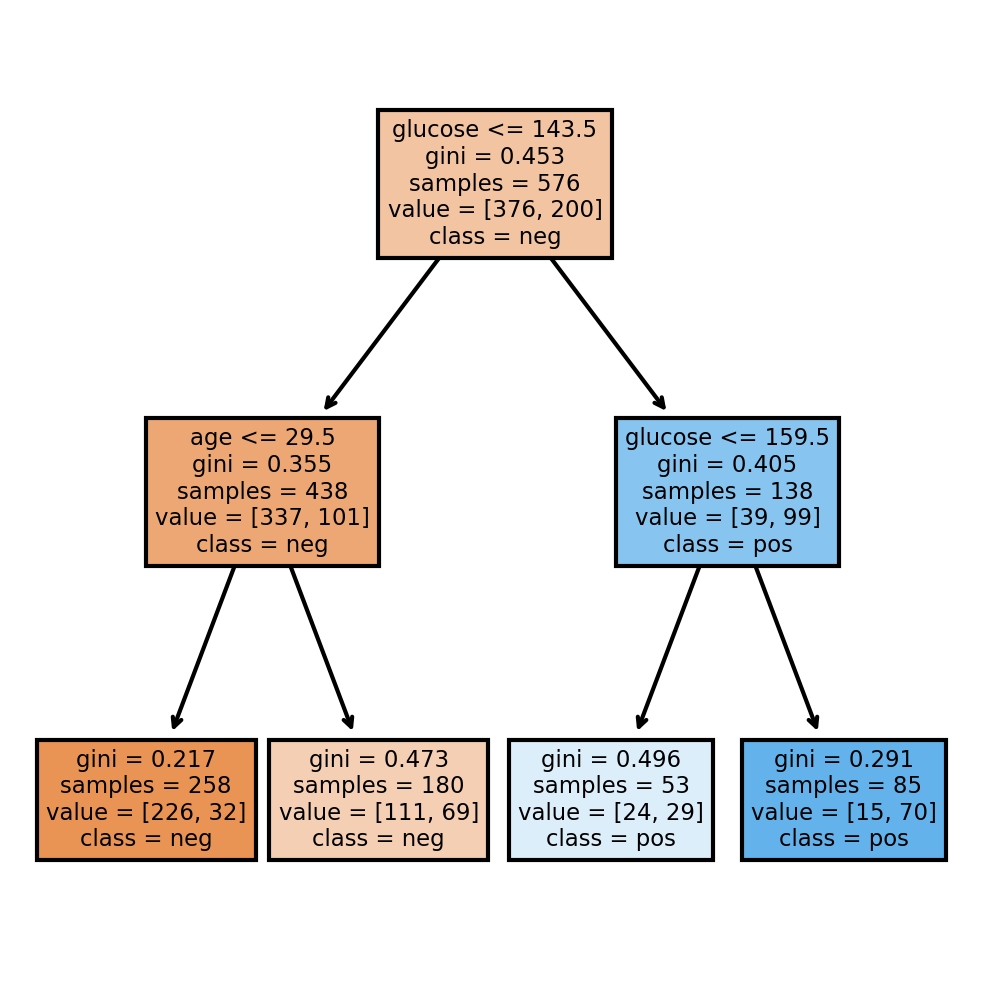

In [96]:
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
myp = tree.plot_tree(dtf,feature_names = list(X.columns), 
               class_names=(['neg','pos']),
               filled = True)

In [97]:
print(tree.export_text(dtf))

|--- feature_1 <= 143.50
|   |--- feature_7 <= 29.50
|   |   |--- class: 0
|   |--- feature_7 >  29.50
|   |   |--- class: 0
|--- feature_1 >  143.50
|   |--- feature_1 <= 159.50
|   |   |--- class: 1
|   |--- feature_1 >  159.50
|   |   |--- class: 1



That’s pretty understandable and you could show this to someone and they would probably get it without too much explanation as long as they had an awareness of the features in the data set. 
Looks to me like **glucose** is an important variable followed by **mass**. 

It’s a flow chart for decisions about whether someone has diabetes or not. Note that there is also information about what percentages of “pos” or “neg” there are in each branch. 

Notice that the tree concept remains the same even if you have a lot more data as is the case with the Pima Indians data vs the mtcars data frame. 

The “node” at the top is called the “root node” and the lines are “branches” that go either to a “terminal node” or to “leaf nodes” which involve some comparison. 

You might notice that I've limited the **depth** of the trees in large part to make the resulting tree easy to view. We could look at trees of greater depth which might (or not) offer a better model. Here we will set max_depth at 100 which will result in something much less readable. Look at 

Report for Test Data

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       124
           1       0.55      0.53      0.54        68

    accuracy                           0.68       192
   macro avg       0.65      0.65      0.65       192
weighted avg       0.68      0.68      0.68       192

Report for Training Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       376
           1       1.00      1.00      1.00       200

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



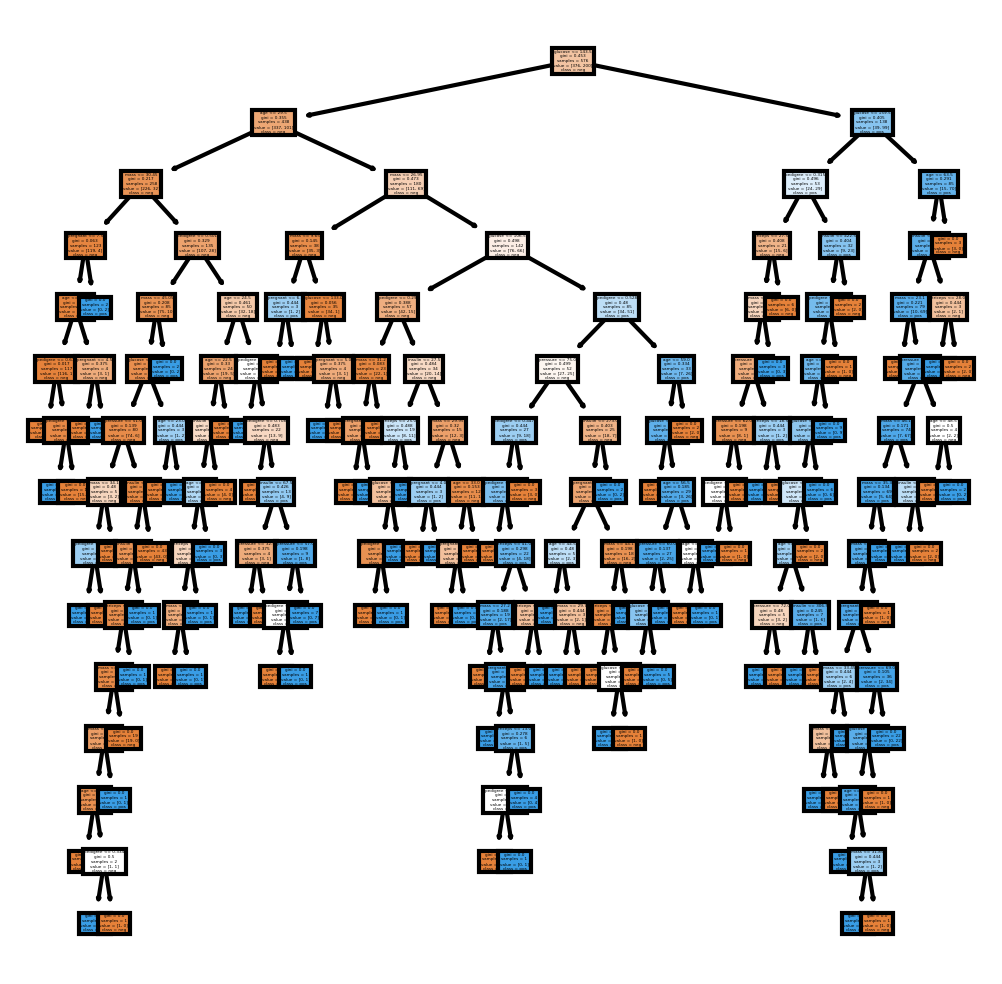

In [98]:
dtf = DecisionTreeClassifier(max_depth=100,random_state=1)

# fitting the data in the pipe 
dtf.fit(X_train, y_train) 
  
# Test scoring data  
print("Report for Test Data\n")
print(classification_report(y_test,dtf.predict(X_test)))

# Train scoring data  
print("Report for Training Data\n")
print(classification_report(y_train,dtf.predict(X_train)))


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
myp = tree.plot_tree(dtf,feature_names = list(X.columns), 
               class_names=(['neg','pos']),
               filled = True)
plt.show()

The above example illustrates some of the problems with a deep tree. Notice that the training acuracy is perfect ! But the test accuracy is pretty medicore. This is a good example of over fitting. The model has become too specific to the training data (or the noise therein). we could either limit the tree depth and experiment with that or we could "prune back" an existing tree. Just as with real trees that might be too dense. 

In [99]:
dtf = DecisionTreeClassifier(min_samples_split=5,max_features=7)

# fitting the data in the pipe 
dtf.fit(X_train, y_train) 
  
# Test scoring data  
print("Report for Test Data\n")
print(classification_report(y_test,dtf.predict(X_test)))

# Train scoring data  
print("Report for Training Data\n")
print(classification_report(y_train,dtf.predict(X_train)))


Report for Test Data

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       124
           1       0.53      0.46      0.49        68

    accuracy                           0.67       192
   macro avg       0.63      0.62      0.62       192
weighted avg       0.66      0.67      0.66       192

Report for Training Data

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       376
           1       0.97      0.92      0.94       200

    accuracy                           0.96       576
   macro avg       0.96      0.95      0.96       576
weighted avg       0.96      0.96      0.96       576



### Feature Importance

One of the cool things about Decision Trees is that the object returns information relating to what it thinks represents the more important features. This is useful for determining what variables might be the most influential in explaining the relationship to an outcome variable. 

Many times, analysts will use a Decision Tree to help figure this out BEFORE using a more specific method. So Trees can be used to figure out the best features after which another method could be used. Check out how to view the information:

Feature Importance:  [0.03831805 0.35653236 0.04797339 0.04846144 0.0546477  0.19824496
 0.12729732 0.12852477]


<Axes: >

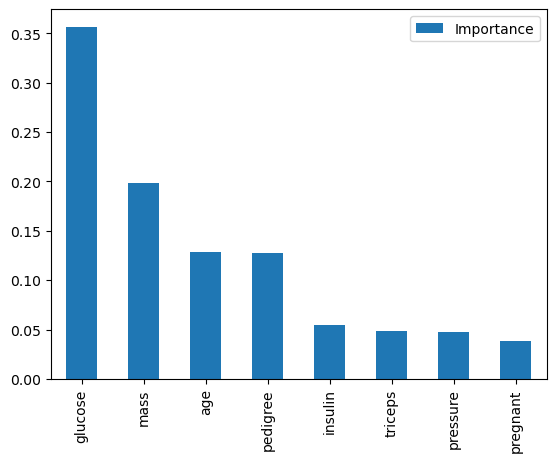

In [100]:
print("Feature Importance: ",dtf.feature_importances_)
feat_importances = pd.DataFrame(dtf.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

The reason this might be useful is that we can use fewer variables to build a model that might be as good at prediction as one which uses all variables. How does the following model compare with the one above which uses all variables ? 

In [101]:
X_small = X[['glucose','mass','age','pedigree']]
# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X_small, y, test_size = 0.25) 

dtf = DecisionTreeClassifier(max_depth=2,random_state=1)

# fitting the data in the pipe 
dtf.fit(X_train, y_train) 

# scoring data  
print(classification_report(y_test,dtf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       117
           1       0.71      0.52      0.60        75

    accuracy                           0.73       192
   macro avg       0.72      0.69      0.70       192
weighted avg       0.73      0.73      0.72       192



And of course, you can build a series of trees using cross validation although we will soon discover that there are better ways to do this. 

In [102]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
from sklearn import tree

scoring = {'prec': 'precision','roc_auc': 'roc_auc',
           'accuracy':'accuracy','recall':'recall'}

dtf = DecisionTreeClassifier()

# Cross Validate is similar to cross_val_score but allows for more than one scoring metric
cv_results = cross_validate(dtf, 
                            X_train, y_train, cv=5, scoring=scoring)
# Convert dict to dataframe
cv_df = pd.DataFrame.from_dict(cv_results)
print(cv_df)

   fit_time  score_time  test_prec  test_roc_auc  test_accuracy  test_recall
0  0.006122    0.012709   0.510204      0.664669       0.672414     0.641026
1  0.002218    0.004723   0.459459      0.593814       0.643478     0.447368
2  0.003914    0.004894   0.586207      0.645762       0.713043     0.447368
3  0.002200    0.006419   0.487179      0.612011       0.652174     0.487179
4  0.002723    0.004168   0.533333      0.669534       0.686957     0.615385


,test_prec,test_roc_auc,test_accuracy,test_recall
count,5.000000,5.000000,5.000000,5.000000
mean,0.515277,0.637158,0.673613,0.527665
std,0.048187,0.033129,0.027848,0.093648
min,0.459459,0.593814,0.643478,0.447368
25%,0.487179,0.612011,0.652174,0.447368
50%,0.510204,0.645762,0.672414,0.487179
75%,0.533333,0.664669,0.686957,0.615385
max,0.586207,0.669534,0.713043,0.641026


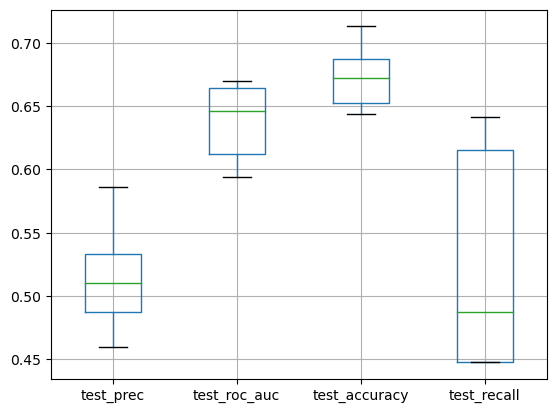

In [103]:
cv_df.boxplot(column=['test_prec','test_roc_auc','test_accuracy','test_recall'])

# Get summary stats
cv_df.iloc[:,2:6].describe()

## Tree Splitting

The resulting tree can be thought of as an upside down tree with the root at the top. The “trunk” proceeds downward and splits into subsets based on some decision (hence the word “decision” in the title). When classifying data the idea is to segment or partition data into groups/regions where each group contains or represents a single class (“yes/no”, “positive/negative”).

These groups or regions would represent a “pure” region. This is not always possible so a best effort is made. These regions are separated by decision boundaries which are used to make decisions. We’ll plot some example data to illustrate the case.

<img src="pics/cool_data.png" width ="600" height=600>

<img src="pics/cdc.png" width ="600" height=600>

<img src="pics/cdci.png" width ="600" height=600>

## Gini Vs Entropy

We could begin to experiment with building more than one trees and adjusting one or more **hyperparameters** of a tree to see if it makes a difference. For example, we could use a different information criterion we build to see if and to what extent if impacts the result accuracy or whatever peformance measure we selected. The criterion argument allows us to specify the function to measure the quality of a split. 


Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. This brings up the whole issue of tuning hyperparameters which is something we will soon explore. Gini is the defauly whereas entropy is thougt to give better performance. 

<img src="pics/infogain.png" width ="600" height=600>


<Axes: title={'center': 'test_score'}, xlabel='criteria'>

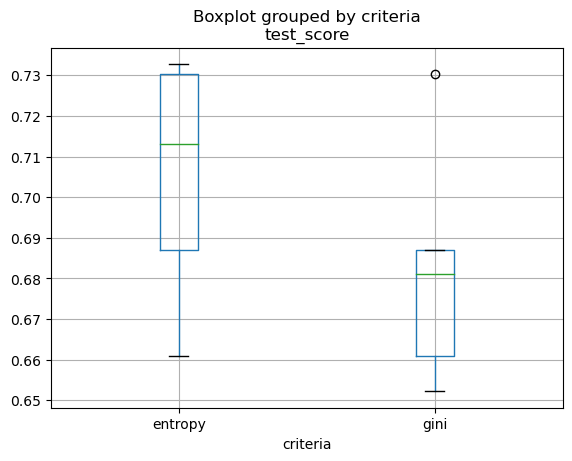

In [104]:
models = dict()
criteria = ['gini','entropy']

for criterion in criteria:
    dtf = DecisionTreeClassifier(criterion=criterion)
    models[criterion] = pd.DataFrame.from_dict(cross_validate(dtf, 
                                                              X_train, 
                                                              y_train, 
                                                              cv=5, 
                                                              scoring='accuracy'))
    models[criterion]['criteria'] = criterion
    
score_df = pd.concat(models.values(), ignore_index=True)
score_df.boxplot('test_score',by='criteria')

One important thing to notice is that trees can change significantly across invocations of the method. Here were do a 3 fold split and build a tree on each of the folds and the apply the model to the holdout. We print the tree and the accuracy.

In [105]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
ii = 1
for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
     y_train, y_test = y[train_index], y[test_index]
     dtf = DecisionTreeClassifier(max_depth=4)
     dtf.fit(X_train,y_train)
     print("Accuracy Score for Tree %d is %3.2f" % (ii,dtf.score(X_test,y_test)))
     print(tree.export_text(dtf,feature_names=X.columns.values.tolist(),max_depth=3))
     ii = ii + 1
     feat_importances = pd.DataFrame(dtf.feature_importances_, index=X.columns, columns=["Importance"])
     feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
     print("Important Features: \n",feat_importances)

Accuracy Score for Tree 1 is 0.72
|--- glucose <= 137.50
|   |--- mass <= 26.35
|   |   |--- pregnant <= 9.50
|   |   |   |--- class: 0
|   |   |--- pregnant >  9.50
|   |   |   |--- age <= 30.50
|   |   |   |   |--- class: 1
|   |   |   |--- age >  30.50
|   |   |   |   |--- class: 0
|   |--- mass >  26.35
|   |   |--- age <= 28.50
|   |   |   |--- glucose <= 127.50
|   |   |   |   |--- class: 0
|   |   |   |--- glucose >  127.50
|   |   |   |   |--- class: 0
|   |   |--- age >  28.50
|   |   |   |--- pedigree <= 0.63
|   |   |   |   |--- class: 0
|   |   |   |--- pedigree >  0.63
|   |   |   |   |--- class: 1
|--- glucose >  137.50
|   |--- glucose <= 166.50
|   |   |--- age <= 24.50
|   |   |   |--- insulin <= 167.50
|   |   |   |   |--- class: 0
|   |   |   |--- insulin >  167.50
|   |   |   |   |--- class: 0
|   |   |--- age >  24.50
|   |   |   |--- glucose <= 146.50
|   |   |   |   |--- class: 1
|   |   |   |--- glucose >  146.50
|   |   |   |   |--- class: 1
|   |--- glucose > 

## Bagged Trees

Now we look at bagged trees which involves looking at many trees in aggregate - this is an ensemble method. It helps to reduce the variance associated with a single decision tree which can be highly sensitive to changes in data. The term bagging refers to “bootstrap aggregation”. Here is the description from the scikit-learn reference on Bagging.

> A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

The bootstrap method of sampling will resample the training data some number of times (with replacement) and retrain a number of models on the resampled data to average out the error. This looks something like:

1) The input data set is resampled with replacement some number of times (e.g. 10,50, 100)

2) The data is sampled with repalcement which leaves some portion of the 
   data available to use a mini test set for prediction (“out of bag data”")

3) Get the prediction om the OOB data and evaluate it according to some measure 
   (e.g. sensitivity, AUC)

4) Average out the performance measure from number. Take the mode for classification or
   accept a majority vote.

<img src="pics/bagging.png" width ="600" height=600>

See [Wikipedia Commons](https://commons.wikimedia.org/wiki/File:DTE_Bagging.png) 

Below we work with the same data as above and ask for 500 trees to be generated which uses 7 features per tree. In this fashion we can further offset any over-training that might happen by using all features. 


In [106]:
from sklearn.ensemble import BaggingClassifier

# Build a Bagging Classifier
model = BaggingClassifier(n_estimators=500,max_features=7,random_state=2)

# Fit the data to training info and make prediction on test data
model.fit(X_train, y_train.ravel())
y_test_preds = model.predict(X_test)

print("Number of estimators:",model.n_estimators)
print(classification_report(y_test,y_test_preds))

Number of estimators: 500
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       167
           1       0.73      0.58      0.65        89

    accuracy                           0.78       256
   macro avg       0.77      0.74      0.75       256
weighted avg       0.78      0.78      0.77       256



In [107]:
from sklearn.metrics import recall_score, accuracy_score

# Build a Bagging Classifier

trees = [100,250,500,750,1000,1500]

for tree in trees:
    model = BaggingClassifier(n_estimators=tree,max_features=7,random_state=2)
    model.fit(X_train, y_train.ravel())
    y_test_preds = model.predict(X_test)
    print("Number of estimators:",model.n_estimators)
    print(round(accuracy_score(y_test,y_test_preds),3))

Number of estimators: 100
0.789
Number of estimators: 250
0.805
Number of estimators: 500
0.781
Number of estimators: 750
0.793
Number of estimators: 1000
0.785
Number of estimators: 1500
0.789


The advantage of using bagged trees over a single tree is that you can generate a number of trees to offset the potentially high variance observed in a single tree. You get the benefit of independent trees that "weigh in" on the classification outcome for an observation. This is different from generating a lot of individual trees. If we consider each tree to be an "estimator" we can take the "weak" estimators (those trees that perform poorly on the OOB data) and combine them with better performing estimators for an aggregate estimator with hopefully good performance. 

Advantages:

  - So having a number of learners, weak or otherwise, can perform substantially better
    than a single tree over a full data set which will typically lead to overfit. 
    
  - Offsets variance in high-variance low-bias data sets
    
  - Trees can be created in parallel and later combined
    
Disadvantages:

  Because we rely upon several trees, we don't have just a single tree to refer 
  back to when discussing "the ultimate model". It's a voting based prediction that 
  uses all estiamtors / trees, not just a single one. 


In [108]:
# Build a Bagging Classifier
model = BaggingClassifier(n_estimators=10)

# Fit the data to training info and make prediction on test data
model.fit(X_train, y_train.ravel())

BaggingClassifier()

In [109]:
print(model.estimator_)
model.estimators_

DecisionTreeClassifier()


[DecisionTreeClassifier(random_state=338265777),
 DecisionTreeClassifier(random_state=361765641),
 DecisionTreeClassifier(random_state=1360422854),
 DecisionTreeClassifier(random_state=101184651),
 DecisionTreeClassifier(random_state=264358865),
 DecisionTreeClassifier(random_state=332173678),
 DecisionTreeClassifier(random_state=784425247),
 DecisionTreeClassifier(random_state=901359199),
 DecisionTreeClassifier(random_state=1072703612),
 DecisionTreeClassifier(random_state=1792278645)]

It bears repeating that if we consider each tree to be an "estimator" we can take the "weak" estimators (those trees that perform poorly on the OOB data) and combine them with better performing estimators for an aggregate estimator with hopefully good performance. 

### Random Forests

One of the extensions to bagged trees involves using Random Forests. In bagging, all features are used when considering if and when to split. Well, that's not entirely true because as with Decision Trees we can set the number of features to be considered. With the Random Forest approach, a subset of features are selected at random at each split in a decision tree. You could think of random forests as being an extension of Bagged Trees. Typically they are also an improvement. Like with Bagged Trees, Random Forests are a parallel method. 

Random forests perform well for multi-class object detection and bioinformatics, which tends to have a lot of statistical noise. 

Since we are talking about trees here, we don’t have to worry a lot about preprocessing the data although we could if we wanted to. Basically, one of the main advantages of tree methods is that it tolerates a combination of data types on different scales which makes it good as a “go to” method for beginners.

Random forests will sample some number of features when considering a split. This can be influenced by a hyperparameter called max_features which is limited to the number of features in the data set.

   fit_time  score_time  test_prec  test_roc_auc  test_accuracy  test_recall
0  0.688312    0.073424   0.606061      0.787106       0.718447     0.555556
1  0.626613    0.073098   0.807692      0.848259       0.805825     0.583333
2  0.616235    0.071681   0.571429      0.722012       0.696078     0.555556
3  0.626935    0.071813   0.857143      0.835227       0.794118     0.500000
4  0.623847    0.072261   0.692308      0.825586       0.754902     0.514286


,test_prec,test_roc_auc,test_accuracy,test_recall
count,5.000000,5.000000,5.000000,5.000000
mean,0.706926,0.803638,0.753874,0.541746
std,0.123962,0.051007,0.047210,0.033940
min,0.571429,0.722012,0.696078,0.500000
25%,0.606061,0.787106,0.718447,0.514286
50%,0.692308,0.825586,0.754902,0.555556
75%,0.807692,0.835227,0.794118,0.555556
max,0.857143,0.848259,0.805825,0.583333


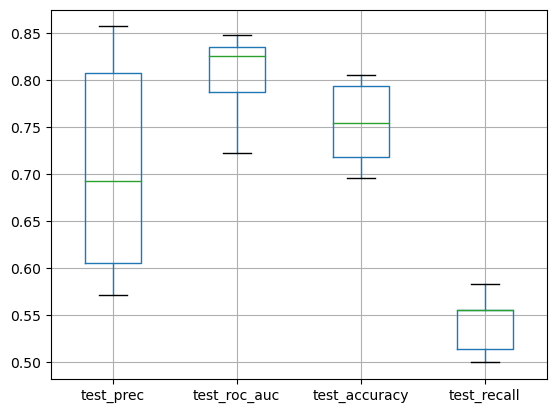

In [110]:
from sklearn.ensemble import RandomForestClassifier

scoring = {'prec': 'precision','roc_auc': 'roc_auc',
           'accuracy':'accuracy','recall':'recall'}

rf = RandomForestClassifier(n_estimators=1000,
                            max_features='sqrt',
                            random_state=1)

# Cross validate
cv_results = cross_validate(rf, 
                            X_train, y_train.ravel(), 
                            cv=5, 
                            scoring=scoring)

# Convert dict to dataframe
cv_df = pd.DataFrame.from_dict(cv_results)
print(cv_df)

cv_df.boxplot(column=['test_prec','test_roc_auc','test_accuracy','test_recall'])

cv_df.iloc[:,2:6].describe()

## Boosted Trees

We’ll finish off this section with a discussion on boosted trees. Here is how we have been progressing thus far:

    1. Single Decision Tree
    2. Bagged Decision Trees (Aggregated Trees using all features)
    3. Random Forests (Many Trees using a number of of sampled features)

Methods 2 and 3 will use bootstrap sampling on the input data which means there will be sampling with replacement to generate a training set. After a tree is built then it will be applied to the OOB (Out Of Band) data left over from the bootstrap sample. This will then be used in the computation of an average.

With boosting, we don’t try to keep up with the idea of reducing the variance emerging from a number of individual trees (aka “learners”). Nor do we consider each tree as being independent and later try to integrate it into an average tree. With boosting we create a sequence of trees such that any subsequent tree represents an improvement on the previous tree(s) thus there is some dependency in the interest of improvement. 

The "learners" do not have to be paricularly good. just slightly better than say flopping a coin to make a decision. Subsequent learners can go to work on the task of identifying and improving the mistakes of the past. 

The process attempts to learn from previous “mistakes” in the creation of down stream trees which can be "stumps". Boosting looks at the residuals from a tree and pays attention to any problematic observations when creating a subsequent tree. Here is an example. We’ll need to do a bit more prep on the data though prior to use:

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

# Instantiate the Booster
ada = AdaBoostClassifier(n_estimators=300)

# Get the scores
n_scores = cross_val_score(ada, 
                           X, y, 
                           scoring = 'accuracy', 
                           cv=8, n_jobs=-1, 
                           error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

ada.fit(X,y.ravel())

Accuracy: 0.755 (0.045)


AdaBoostClassifier(n_estimators=300)

From the scikit-learn documentation:

> Finally, this module also features the parallel construction of the trees and the parallel computation of the predictions through the n_jobs parameter. If n_jobs=k then computations are partitioned into k jobs, and run on k cores of the machine. If n_jobs=-1 then all cores available on the machine are used. Note that because of inter-process communication overhead, the speedup might not be linear (i.e., using k jobs will unfortunately not be k times as fast)

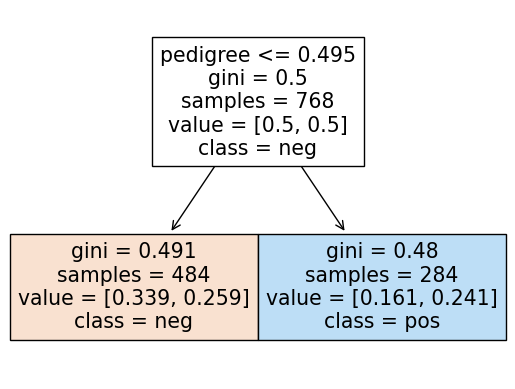

In [67]:
from sklearn import tree
myada = tree.plot_tree(ada.estimators_[4],
                       feature_names=list(X.columns),class_names=(['neg','pos']),
               filled = True)

In [77]:
voting_results = []
for estimator in ada.estimators_:
    voting_results.append(estimator.predict(X_test.iloc[1,:].values.reshape(1,-1)))

# So count all the votes
print("Voting Results:\n",pd.DataFrame(voting_results).value_counts())

# Does this match reality ?
print("Observation 1 was actually:",y_test[1])

Voting Results:
 1    155
0    145
dtype: int64
Observation 1 was actually: [1]


## Trees For Regression

Predicting numeric outcomes can also be of interest. Given some patient characteristics relative to a disease, we might want to predict a viral load quantity. A gambler might want to predict a final score for a team. Unlike, classification problems, we are looking at estimating a numeric outcome. In addition to a Randon forest classification method, there is also one that permits Regression to predict a continuous outcome. We'll go back to our mtcars example and use Random Forests to predict the **mpg** variable. the cool think about using trees is that we do not have to worry about normalizing data (not that that is hard) or the mixture of quantitative and categorical data.

Since we are predicting a numeric outcome we would like to come up with a metric to help us figure out if the model we have is good or not. With classification situations we can employ confusion matrices and ROC curves. Here we will use something more simplistic but effective - Root Mean Square Error. The formula looks like the following where P represents a vector of predictions and O represents a vector of the observed (true) values.

$$RMSE = \sqrt\frac{\sum_i^n(P_i-O_i)^2}{n}$$

In [68]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"
mtcars = pd.read_csv(url)

X = mtcars.drop('mpg',axis=1)
y = mtcars.mpg

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20,
                                                    random_state=10) 
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
print("RMSE: ",mean_squared_error(y_test,forest.predict(X_test)))


RMSE:  7.156391285714335


So let's up the number of estimators in the Random Forests.

In [69]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"
mtcars = pd.read_csv(url)

X = mtcars.drop('mpg',axis=1)
y = mtcars.mpg

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20,
                                                    random_state=10) 

forest = RandomForestRegressor(max_depth=100,max_leaf_nodes=6)
forest.fit(X_train, y_train)
print("RMSE: ",mean_squared_error(y_test,forest.predict(X_test)))

RMSE:  6.684235147932989


We could use something like Repeated Kfold validation to see how performant our Regression trees perform over a series of repeated folds. 

In [70]:
# We have to designate a scoring metric 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold

mse = make_scorer(mean_squared_error)

forest = RandomForestRegressor(900)
# The cross_validate function handles the execution of the model
# as well as the management of the folds

cv  = cross_validate(forest,X,y,scoring=(mse), cv=8, return_train_score=True)

# Here we print out the rmse of the test / holdout data
print("Test RMSE per fold:",(cv['test_score']**0.5))

# Look at the mean of this RMSE array
print("Mean Test RMSE:",(cv['test_score']**0.5).mean().round(2))

# Look at the mean of this RMSE array
print("Mean Train RMSE:",(cv['train_score']**0.5).mean().round(2))

Test RMSE per fold: [2.7024986  1.4588698  1.12617368 4.13410779 5.22938924 2.6014774
 3.56249638 1.2780126 ]
Mean Test RMSE: 2.76
Mean Train RMSE: 0.88


## Parameters Vs HyperParameters

Model parameters are things that are generated as part of the modeling process. These might be things like slope and intercept from a linear model or, in the case of a Decision Tree, the number of splits in the final tree or the total number of leaves.

Hyper parameters (sometimes called metaparameters) represent information that is supplied in the form of an argument **prior** to the call to the method to generate results. These parameters might not be something one can intelligently set without some experimentation. Obviously, the more theoretical or background knowledge one has about a given method then the easier it becomes to establish "better" values for arguments than the defaults. 

Most modeling functions have default values for various arguments but this does not mean that the defaults are appropriate for all cases. You can always view the documentation for a given function such as the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Note that there are a number of parameters which could be set in conjunction with other parameters that might, or not, yield a more accurate or sensitive model. 

<img src="pics/skle.png" width ="700" height=700>

Earlier, we experimented with the "criteria" hyperparameter to see which one gave the best performance. This was a manual process and somewhat cumbersome especially when considering what we might do should we want to change other parameters in combination with the criteria.

<Axes: title={'center': 'test_score'}, xlabel='criteria'>

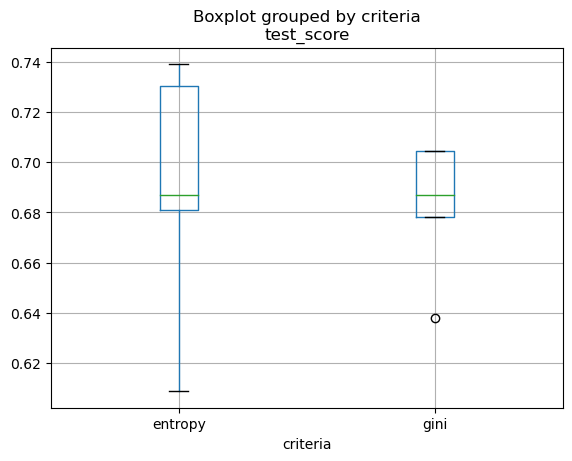

In [71]:
X = pm.drop('diabetes',axis=1)
y = pm.diabetes

lb = preprocessing.LabelBinarizer(neg_label=0, pos_label=1)
y  = lb.fit(y).transform(y)

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 


models = dict()
criteria = ['gini','entropy']

for criterion in criteria:
    dtf = DecisionTreeClassifier(criterion=criterion)
    models[criterion] = pd.DataFrame.from_dict(cross_validate(dtf, 
                                                              X_train, 
                                                              y_train, 
                                                              cv=5, 
                                                              scoring='accuracy'))
    models[criterion]['criteria'] = criterion
    
score_df = pd.concat(models.values(), ignore_index=True)
score_df.boxplot('test_score',by='criteria')

In [72]:
dtf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'max_features': ["sqrt", "log2"]}

# decision tree model
dtree_model=DecisionTreeClassifier()

#use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=8, scoring='accuracy')

#fit model to data
dtree_gscv.fit(X_train, y_train)
    
print(dtree_gscv.best_params_)

best_estim = dtree_gscv.best_estimator_

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2'}


In [76]:
sorted(dtree_gscv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [77]:
grid_predictions = best_estim.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       129
           1       0.66      0.60      0.63        63

    accuracy                           0.77       192
   macro avg       0.73      0.72      0.73       192
weighted avg       0.76      0.77      0.76       192



In [78]:
dtree_gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [41]:
pm

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,pos
1,1,85,66,29,0,26.6,0.351,31,neg
2,8,183,64,0,0,23.3,0.672,32,pos
3,1,89,66,23,94,28.1,0.167,21,neg
4,0,137,40,35,168,43.1,2.288,33,pos
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,neg
764,2,122,70,27,0,36.8,0.340,27,neg
765,5,121,72,23,112,26.2,0.245,30,neg
766,1,126,60,0,0,30.1,0.349,47,pos


In [87]:
from sklearn.feature_selection import SelectKBest, chi2
bestf = SelectKBest(score_func=chi2,k=8)
fit = bestf.fit(X,y)

In [88]:
fit.scores_

array([ 111.51969064, 1411.88704064,   17.60537322,   53.10803984,
       2175.56527292,  127.66934333,    5.39268155,  181.30368904])

In [44]:
from IPython.display import Image
Image(url='http://python.org/images/python-logo.gif')

In [89]:
rf = RandomForestClassifier(n_estimators=100,
                            max_features='sqrt',
                            random_state=1,
                           oob_score=True)
rf.fit(X,y.ravel())

RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1)